# Importing Libraries

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from IPython.display import display 

In [18]:
#Choose from the list of folders - 'MFCC', 'LinearSpectrum', 'MelSpectrum', 'GTCC', 'SpectralDescriptorFeatures', 'Pitch', 'All_Features', 'PaperFeatures', 'PaperFeatures_NoPreprocessing'
directory = '/content/drive/MyDrive/BP_And_Speech_Analysis/PreprocessedData/PaperFeatures/'

# Importing Patient Meta Data and Basic Preprocessing of Dataframe

In [19]:
#Reading the patient data
patientTrain = pd.read_csv(directory + 'patientTrain.csv')
trainFileNames = patientTrain["FileName"]
patientTest = pd.read_csv(directory + 'patientTest.csv')
testFileNames = patientTest["FileName"]

#Combining the train and test meta data for basic preprocessing
testIndex = patientTrain.shape[0]
Combined = patientTrain.append(patientTest)


Combined = Combined.drop(columns= ["FileName", "HeartbeatRate"])
dtype_dict = {'Gender' : 'category',
              'Age' : 'float64',
              'Weight': 'float64',
              'Size' : 'float64',
              'SystolicBP': 'float64',
              'DiastolicBP': 'float64'};
Combined = Combined.astype(dtype_dict);
Combined.rename(columns= {'Size' : 'Height'}, inplace=True);


#One-hot encoding categorical feature 'Gender'
genderBinarizer = LabelBinarizer().fit(Combined["Gender"])
Combined["Gender"] = genderBinarizer.transform(Combined["Gender"])

#Separating the data back into test and train dataframes
patientTrain = Combined.iloc[0:testIndex];
patientTest = Combined.iloc[testIndex : ];

#Separating predictors and response variables
Xtrain = patientTrain[["Gender", "Age", "Weight", "Height"]];
Ytrain = patientTrain[["SystolicBP", "DiastolicBP"]]

Xtest = patientTest[["Gender", "Age", "Weight", "Height"]];
Ytest = patientTest[["SystolicBP", "DiastolicBP"]]

#Separating the predictors into continuous and categorical features inorder to  
#standardize the continuous features separately
continuous = ["Age", "Weight", "Height"];
categorical = ["Gender"];

trainCategorical = Xtrain[categorical];
trainContinuous = Xtrain[continuous];

testCategorical = Xtest[categorical];
testContinuous = Xtest[continuous];

#Standardization of continuous features
Xscaler = StandardScaler().fit(trainContinuous);
trainContinuous = Xscaler.transform(trainContinuous);
testContinuous = Xscaler.transform(testContinuous);

#Combining the predictors
Xtrain = np.hstack((trainContinuous,  trainCategorical.to_numpy()));
Xtest = np.hstack((testContinuous, testCategorical.to_numpy()));

#Standardizing Response Variables
Yscaler = StandardScaler().fit(Ytrain);
Ytrain = Yscaler.transform(Ytrain);
Ytest = Yscaler.transform(Ytest);


# Data Visualization Section

Plots to gain better understanding of the data in the tables

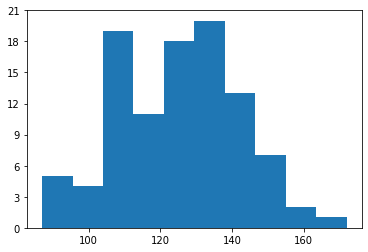

In [20]:
#Plotting Diastolic Blood Pressure Distribution
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(patientTrain["SystolicBP"]);

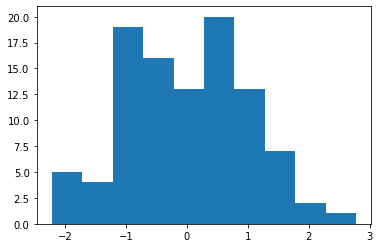

In [21]:
#After preprocessing
plt.hist(Ytrain[:, 0]);

# Importing the Preprocessed Audio Data

In this section, we load the audio data of the patients. The .csv files were obtained after preprocessing the .wav files, extracting features, and normalizing the audio features using MATLAB.

In [22]:
#Reading a train file to check shape
sample = pd.read_csv(directory + "TrainFiles/" + trainFileNames[0] + ".csv", header = None).to_numpy();
rows, cols = sample.shape

In [23]:
numTrain = Xtrain.shape[0];
numTest = Xtest.shape[0];

#Using pre-defined the audioTrain matrix to speed up loading.
#On using a list, its size will have to change dynamically, which will slow down
#the loading=
audioTrain = np.zeros([numTrain, rows, cols], dtype = np.float64);
for i in range(numTrain):
  audioTrain[i, :, :] = pd.read_csv(directory + "TrainFiles/" + trainFileNames[i] + ".csv", header = None).to_numpy();
  #Remember to set header = None, otherwise the first row of the matrix will be assumed to contain column names,
  # and hence will be neglected

#Similarly, loading the test audio feature files
audioTest = np.zeros([numTest, rows, cols], dtype = np.float64);
for i in range(numTest):
  audioTest[i, :, :] = pd.read_csv(directory + "TestFiles/" + testFileNames[i] + ".csv", header = None).to_numpy();

#Adding dummy channels
#audioTrain = audioTrain[..., np.newaxis];
#audioTest = audioTest[..., np.newaxis];

#Checking whether the data is loaded into correct shapes or not
print("Train file shapes: \n", audioTrain[0].shape);
print(audioTrain.shape);
print("Train file shapes: \n", audioTest[0].shape);
print(audioTest.shape);

Train file shapes: 
 (630, 1)
(100, 630, 1)
Train file shapes: 
 (630, 1)
(14, 630, 1)


# Developing and Training Network

In [24]:
from tensorflow.keras import layers, models
import tensorflow as tf
import keras.utils.losses_utils as losses_utils
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
model = models.Sequential()

#Convolutional layers
convParams = [(3, 7), (10, 5), (20, 3)]

for (numFilters, kernel) in convParams:

  model.add(layers.Conv1D(numFilters, kernel, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.01))
  model.add(layers.AveragePooling1D(pool_size=2, strides=2))
  model.add(layers.BatchNormalization(axis=[1, 2]))

model.add(layers.MaxPool1D(pool_size=2, strides=2))
model.add(layers.Flatten())
#Dense Layers
denseParams = [16*rows, 2*rows, 64, 16]
for (i, param) in enumerate(denseParams):

  model.add(layers.Dense(param))
  model.add(layers.LeakyReLU(alpha=0.01))
  if i == 0:
    model.add(layers.Dropout(0.3))

#Regression layer
model.add(layers.Dense(2, activation='linear')) 

In [26]:
mse_loss = tf.keras.losses.MeanSquaredError(reduction=losses_utils.ReductionV2.AUTO, name='mean_squared_error')
mse_metrics = tf.keras.metrics.mean_squared_error

model.compile(optimizer='adam', loss=mse_loss)#, metrics=[mse_metrics])

In [27]:
# train the model
callback = EarlyStopping(monitor='loss', patience=3)
print("[INFO] training model...")
model.fit(
	x=audioTrain, y=Ytrain,
  validation_split = 0.1,
  #validation_data=(audioTest, Ytest),
	epochs=50, batch_size=None,
  callbacks= [callback])
# make predictions on the testing data
print("[INFO] predicting Blood Pressures...")
preds = Yscaler.inverse_transform(model.predict(audioTest))

[INFO] training model...
Epoch 1/50
3/3 [==============================] - 3s 340ms/step - loss: 6.9177 - val_loss: 1.1170
Epoch 2/50
3/3 [==============================] - 1s 251ms/step - loss: 1.6658 - val_loss: 1.1422
Epoch 3/50
3/3 [==============================] - 1s 221ms/step - loss: 1.1164 - val_loss: 1.1825
Epoch 4/50
3/3 [==============================] - 1s 229ms/step - loss: 1.2272 - val_loss: 1.1410
Epoch 5/50
3/3 [==============================] - 1s 229ms/step - loss: 1.4994 - val_loss: 1.1350
Epoch 6/50
3/3 [==============================] - 1s 235ms/step - loss: 1.2817 - val_loss: 1.1292
[INFO] predicting Blood Pressures...


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 630, 3)            24        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 630, 3)            0         
_________________________________________________________________
average_pooling1d_3 (Average (None, 315, 3)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 315, 3)            3780      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 315, 10)           160       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 315, 10)           0         
_________________________________________________________________
average_pooling1d_4 (Average (None, 157, 10)          

In [29]:
original_Ytest = Yscaler.inverse_transform(Ytest)
deviations = preds - original_Ytest

for i in range(preds.shape[1]):

  if i==0:
    results = np.column_stack((original_Ytest[:, i], preds[:, i], deviations[:, i]))
  else:
    results = np.column_stack((results, original_Ytest[:, i], preds[:, i], deviations[:, i]))

choice = 3
if choice == 1:
  columns=["Systolic", "Pred_Systolic", "Dev_Systolic"]
elif choice == 2:
  columns=["Diastolic", "Pred_Diastolic", "Dev_Diastolic"]
elif choice == 3:
  columns=["Diastolic", "Pred_Diastolic", "Dev_Diastolic", "Systolic", "Pred_Systolic", "Dev_Systolic"]
else:
  print('None')

results = pd.DataFrame(results, columns = columns)
display(results)

,Diastolic,Pred_Diastolic,Dev_Diastolic,Systolic,Pred_Systolic,Dev_Systolic
0,136.0,125.600975,-10.399025,112.0,68.357964,-43.642036
1,114.0,125.599899,11.599899,75.0,68.349960,-6.650040
2,104.0,125.591446,21.591446,59.0,68.343521,9.343521
3,138.0,125.560303,-12.439697,73.0,68.329941,-4.670059
4,106.0,125.598122,19.598122,50.0,68.331688,18.331688
5,119.0,125.733871,6.733871,68.0,68.387650,0.387650
6,105.0,129.613495,24.613495,54.0,69.783165,15.783165
7,137.0,127.932129,-9.067871,80.0,69.184792,-10.815208
8,149.0,125.449394,-23.550606,68.0,68.285034,0.285034
9,111.0,125.507095,14.507095,59.0,68.308205,9.308205


In [30]:
if choice != 1:
  dbp_mse = float(mse_metrics(original_Ytest[:, 1], preds[:, 1]))
  print("MSE for Diastolic BP= {:.2f}".format(dbp_mse))

if choice != 2:
  sbp_mse = float(mse_metrics(original_Ytest[:, 0], preds[:, 0]))
  print("MSE for Systolic BP= {:.2f}".format(sbp_mse))

if choice == 3:
  net_mse = (dbp_mse + sbp_mse)/2
  print("Net MSE= {:.2f}".format(net_mse)) 

MSE for Diastolic BP= 231.30
MSE for Systolic BP= 332.48
Net MSE= 281.89


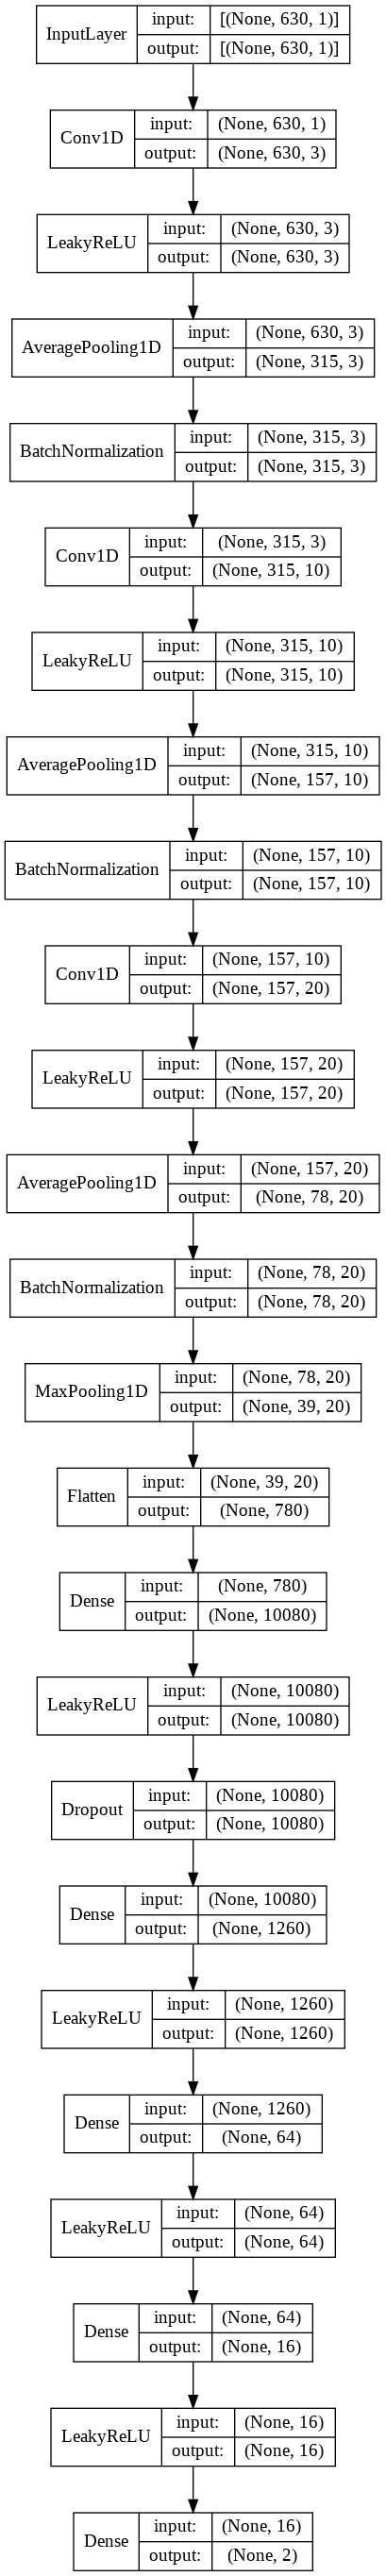

In [31]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, rankdir='TB')

In [32]:
#model.save("trialModel.h5")
